<a href="https://colab.research.google.com/github/Sanjayyellina/Mini-project-1/blob/main/project_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#** Mini Project : 3 What Does the Government Say? Analyzing Sentiment in NYC 311 Resolution Responses Using NLP **

# RPAD 676: Data Science for the Public Good

## Author: Abhinav Sanjay Yellina
## Date: 05/13/2025

## Objective




This project explores the tone of government responses to public service requests submitted through New York City’s 311 system. While most 311 data analyses focus on what issues are being reported or how quickly they are resolved, I wanted to investigate something different: *how* the government communicates its response back to the public. Using Natural Language Processing (NLP), I analyzed the `resolution_description` field—a column that includes official statements issued by agencies to close out complaints.

The core goal was to identify patterns in the sentiment of these responses. I asked questions like: Are some boroughs receiving more negatively worded responses? Are certain complaint types associated with more constructive or dismissive language? This project contributes to the broader theme of data science for public good by offering insights into civic communication, accountability, and equity in government responsiveness.


In [1]:

!pip install -q pandas numpy matplotlib seaborn nltk scikit-learn gensim spacy wordcloud sodapy textblob
!python -m nltk.downloader stopwords punkt wordnet
!python -m spacy download en_core_web_sm
from textblob import download_corpora; download_corpora.download_all()


<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Resta

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from sodapy import Socrata
from datetime import datetime

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from textblob import TextBlob

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [3]:
# Download NLP resources (run once per environment)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import spacy
spacy.cli.download("en_core_web_sm")

from textblob import download_corpora
download_corpora.download_all()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


# Analyzing Sentiment in NYC 311 Resolution Responses Using NLP

#### CONNECT TO NYC OPEN DATA API


In [4]:
client = Socrata("data.cityofnewyork.us", app_token=None)
dataset_id = "erm2-nwe9"



# Paginate to retrieve more than 10,000 records
limit = 10000
offset = 0
MAX_RECORDS = 50000  # Set your custom total limit
all_results = []

# Filter by recent date - change as needed
date_filter = "created_date > '2023-01-01T00:00:00.000'"

while offset < MAX_RECORDS:
    current_limit = min(limit, MAX_RECORDS - offset)
    results = client.get(dataset_id, limit=current_limit, offset=offset, where=date_filter)

    if not results:
        break

    print(f"Fetched records {offset} to {offset + current_limit}")
    all_results.extend(results)
    offset += current_limit
    time.sleep(1)

Fetched records 0 to 10000
Fetched records 10000 to 20000
Fetched records 20000 to 30000
Fetched records 30000 to 40000
Fetched records 40000 to 50000


In [5]:
# Create DataFrame
df = pd.DataFrame.from_records(all_results)
print(f"Total records retrieved: {len(df)}")

Total records retrieved: 50000


In [6]:
# Show columns
print(df.columns)
print(df.head())

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'status', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'city', 'landmark', 'bbl', 'taxi_pick_up_location',
       'facility_type', 'bridge_highway_name', 'bridge_highway_segment',
       'road_ramp', 'bridge_highway_direction', 'vehicle_type',
       'taxi_company_borough', 'due_date'],
      dtype='object')
  unique_key             created_date              closed_date agency  \
0   56417527  2023-01-01T00:00:09.000  2023-01-01T00:36:06.000   NYPD   
1   564

#### PREPROCESSING & FEATURE ENGINEERING

In [7]:
df["created_date"] = pd.to_datetime(df["created_date"], errors='coerce')
df["closed_date"] = pd.to_datetime(df["closed_date"], errors='coerce')
df = df.dropna(subset=["created_date", "closed_date"])

# Ensure the DataFrame is not a view to avoid SettingWithCopyWarning
df = df.copy()
df["response_time_days"] = (df["closed_date"] - df["created_date"]).dt.total_seconds() / 86400


In [8]:
# Remove unreasonable values (e.g., negatives or very long durations)
df = df[(df["response_time_days"] >= 0) & (df["response_time_days"] < 365)]


In [9]:
# Select features and encode categoricals
df_model = df[["complaint_type", "borough", "agency", "response_time_days"]].dropna()
df_model = pd.get_dummies(df_model, columns=["complaint_type", "borough", "agency"], drop_first=True)


#### sentiment Polarity Calculation

In [38]:
from textblob import TextBlob

# Ensure column is string
df['resolution_description'] = df['resolution_description'].astype(str).fillna('')

# Apply TextBlob for sentiment polarity
df['sentiment'] = df['resolution_description'].apply(lambda x: TextBlob(x).sentiment.polarity)

#  Print summary
print(df['sentiment'].describe())


count    48749.000000
mean        -0.045227
std          0.165103
min         -0.500000
25%         -0.133333
50%         -0.066667
75%          0.050000
max          0.500000
Name: sentiment, dtype: float64


#### Sentiment Classification into Labels

In [34]:
# Define a function to classify sentiment polarity
def classify_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the classification to create a new column
df['sentiment_label'] = df['sentiment'].apply(classify_sentiment)

#  Check distribution
print(df['sentiment_label'].value_counts())


sentiment_label
Negative    25833
Positive    15021
Neutral      7895
Name: count, dtype: int64


#### Visualization by Borough

<ipython-input-30-c041ab393006>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.groupby('borough')['sentiment'].mean().sort_values().index,


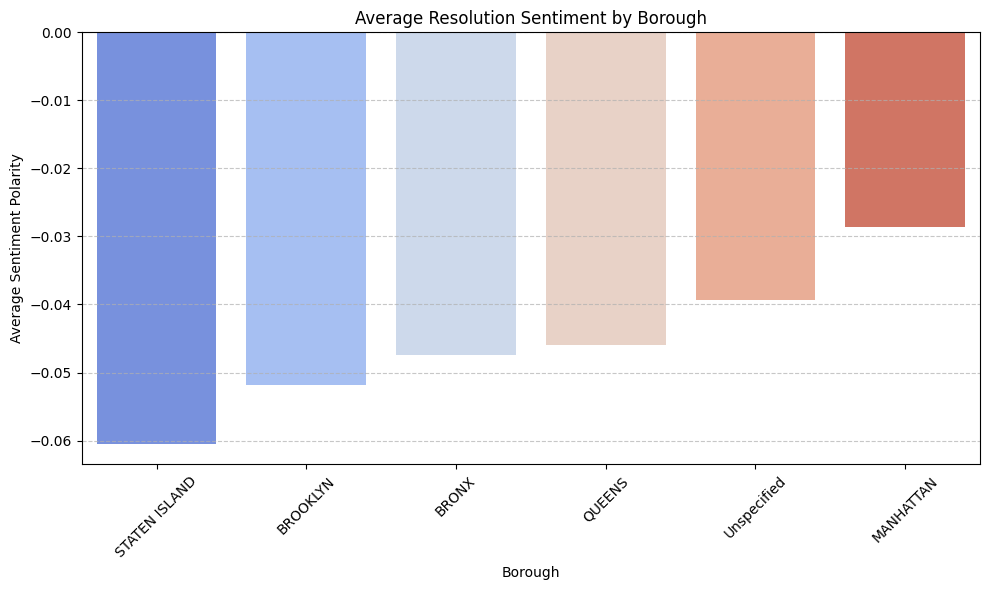

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group and plot
plt.figure(figsize=(10,6))
sns.barplot(x=df.groupby('borough')['sentiment'].mean().sort_values().index,
            y=df.groupby('borough')['sentiment'].mean().sort_values().values,
            palette='coolwarm')
plt.title('Average Resolution Sentiment by Borough')
plt.ylabel('Average Sentiment Polarity')
plt.xlabel('Borough')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


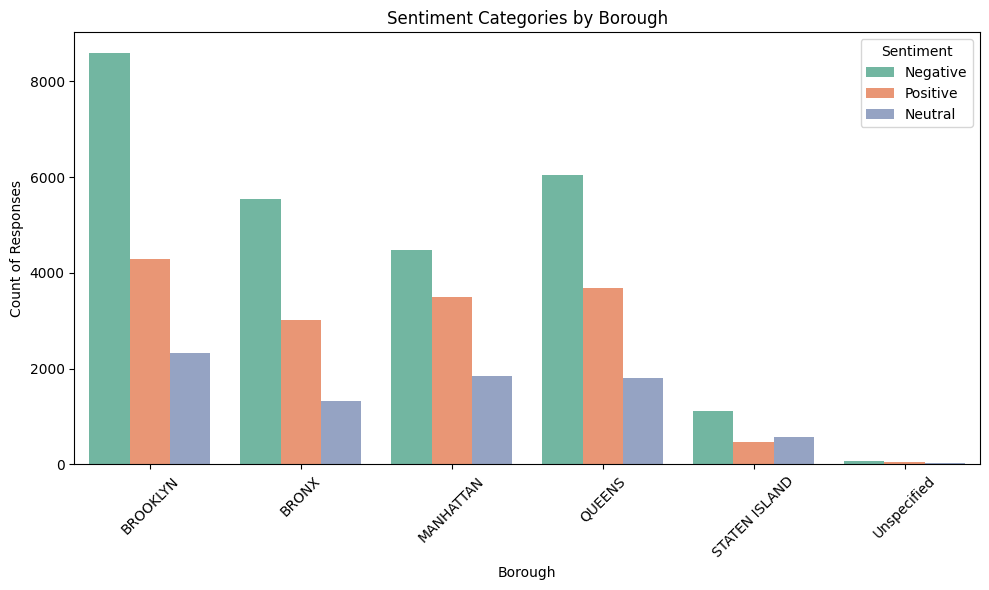

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='borough', hue='sentiment_label', palette='Set2')
plt.title('Sentiment Categories by Borough')
plt.ylabel('Count of Responses')
plt.xlabel('Borough')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


#### Complaint Type vs. Average Sentiment

In [36]:
# Clean complaint_type column
df['complaint_type'] = df['complaint_type'].astype(str).fillna('Unknown')

# Group by complaint type and calculate average sentiment
complaint_sentiment = df.groupby('complaint_type')['sentiment'].mean().sort_values()

#  Display top 10 most negative and most positive
print("\nMost Negatively Responded Complaint Types:")
print(complaint_sentiment.head(10))

print("\nMost Positively Responded Complaint Types:")
print(complaint_sentiment.tail(10))



Most Negatively Responded Complaint Types:
complaint_type
Plant                            -0.316667
Snow or Ice                      -0.300000
Recycling Basket Complaint       -0.300000
LinkNYC                          -0.300000
Transfer Station Complaint       -0.300000
Industrial Waste                 -0.293833
Residential Disposal Complaint   -0.288327
Dumpster Complaint               -0.283000
Dirty Condition                  -0.263259
Commercial Disposal Complaint    -0.257407
Name: sentiment, dtype: float64

Most Positively Responded Complaint Types:
complaint_type
Curb Condition                    0.104944
Uprooted Stump                    0.119231
Institution Disposal Complaint    0.125000
Overgrown Tree/Branches           0.127438
Lead                              0.160000
Highway Condition                 0.165657
New Tree Request                  0.207492
Street Light Condition            0.403739
Traffic Signal Condition          0.405187
Taxi Compliment                  

<ipython-input-37-4abd927b962a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_complaints.values, y=top_complaints.index, palette='coolwarm')


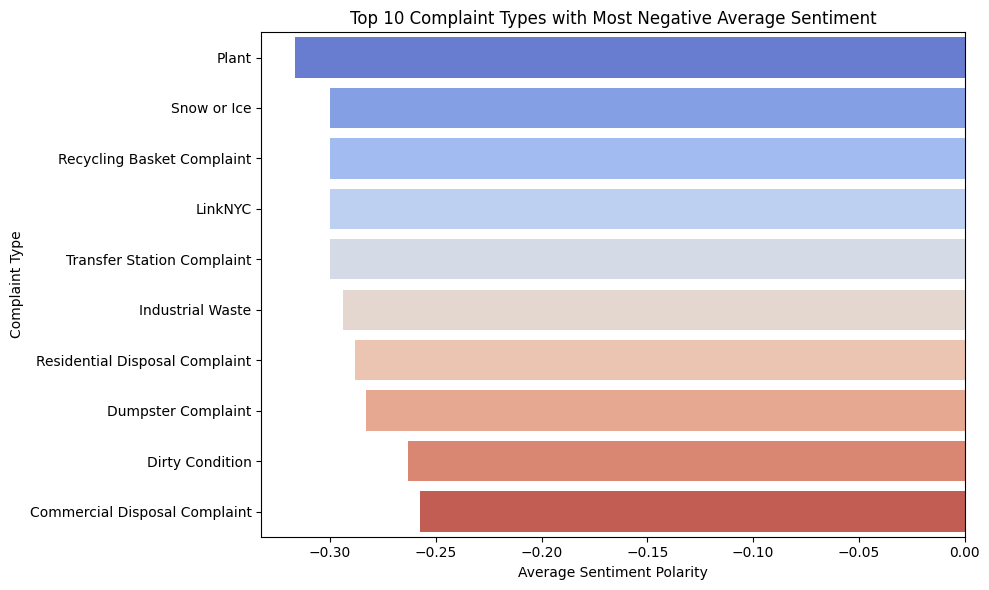

In [37]:
top_complaints = complaint_sentiment[complaint_sentiment.index.str.len() > 2].dropna().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_complaints.values, y=top_complaints.index, palette='coolwarm')
plt.title('Top 10 Complaint Types with Most Negative Average Sentiment')
plt.xlabel('Average Sentiment Polarity')
plt.ylabel('Complaint Type')
plt.tight_layout()
plt.show()
